<a href="https://colab.research.google.com/github/rebsfeitosa/ChurnPredict/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

Para este projeto, nossos pacotes principais serão Pandas para trabalhar com dados, Matplotlib e Seaborn para trabalhar com as visualizações, scikit-learn para divisão de dados, construção e avaliação do modelo de classificação. Vamos importar todos os nossos pacotes primários para o nosso ambiente Python.

In [62]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Importar pacotes importantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importar pacotes de ML
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#Importar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de Machine Learning.


Feito isso, vamos à Análise Exploratória

##Análise Exploratória

Para começar é importante verificar a quantidade de entradas e variáveis do dataset e entender o tipo de dado que cada coluna contém. Também iremos verificar o nome de todas as colunas do dataset e de qual tipo elas são.

In [63]:
#Verificando a quantidade de linhas e colunas do dataset
print('Dimensões do dataset',
      '\nVariáveis: ',df.shape[1], '\n'
      'Entradas: ', df.shape[0])

#Verificando as primeiras entradas do dataset
df.head()

Dimensões do dataset 
Variáveis:  21 
Entradas:  7043


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##Há valores nulos?

Um dos problemas mais comuns que podemos enfrentar na limpeza e exploração de dados é lidar com os valores ausentes. A qualidade de um dataset está diretamente relacionada à quantidade de valores ausentes. É importante entender logo no início se esses valores nulos são significativos comparados ao total de entradas.

In [64]:
#verificando se há valores nulos 
print('Temos valores nulos?', df.isnull().values.any())

Temos valores nulos? False


A maioria dos modelos de Machine Learning esperam dados em formato numérico para fazer as previsões. Por isso é importante verificar o tipo das colunas.

In [65]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

É interessante verificar os dados categóricos cadastrados em determinadas colunas em que há dados diferente de 'Yes' e 'No'

In [66]:
#Entendendo o tipo de dados que existem nas variáveis categóricas
print('MultipleLines:', df['MultipleLines'].unique())
print('InternetService:', df['InternetService'].unique())
print('Contract:', df['Contract'].unique())
print('PaymentMethod:', df['PaymentMethod'].unique())

MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Vou separar os dados para que eu tenha a informação das dimnesões do conjunto de dados que correspondem a clientes que deram churn e o conjunto que os dados correspondem a clientes que não deram churn afim de facilitar a análise e verificar suas dimensões separadamente.


In [67]:
#verificando as dimensões dos datasets com transações normais e fraudulentas

print('Dimensões transações que não deram Churn',
    '\nVariáveis: ',df[df['Churn'] == 'No'].shape[1], "\n"
      'Entradas: ', df[df['Churn'] == 'No'].shape[0])
print('Dimensões transações que deram Churn',
    '\nVariáveis: ',df[df['Churn'] == 'Yes'].shape[1], "\n"
      'Entradas: ', df[df['Churn'] == 'Yes'].shape[0])

Dimensões transações que não deram Churn 
Variáveis:  21 
Entradas:  5174
Dimensões transações que deram Churn 
Variáveis:  21 
Entradas:  1869


É interessante verificar a distruibuição dos dados em algumas variáveis (principalmente o target que é a coluna Churn). Pelos gráficos é possível verificar que a grande maioria dos clientes tem serviços de celular contratados e que o tipo de contrato "preferido" é mensal. Muitos clientes já aderiram receber suas contas de forma digital, mas grande parte ainda prefere a cobrança de papel em casa. Por último, fica evidente que o *dataset* está desbalanceado, já que a quantidade de churning é bem menor.

In [68]:
print(plt.style.available)
plt.style.use('_classic_test_patch')


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


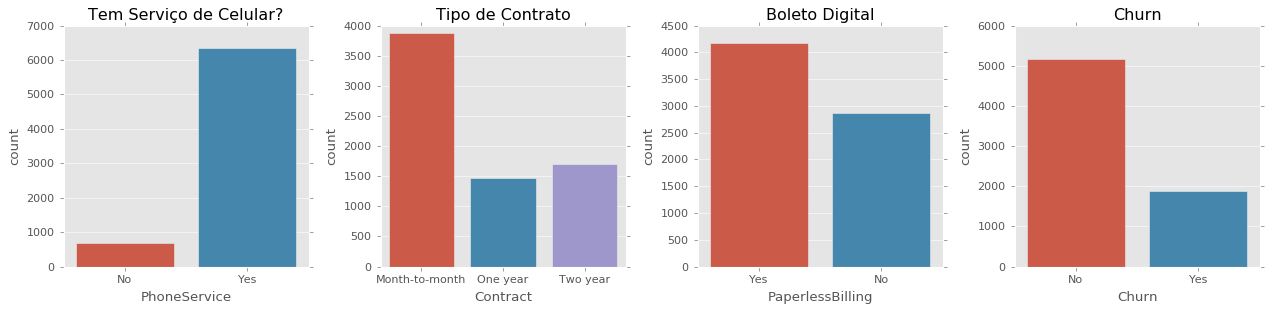

In [74]:
#visualizando o desbalanceamento 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

num_bins = 40

sns.countplot('PhoneService', data=df, ax=ax[0])
ax[0].set_title('Tem Serviço de Celular?')

sns.countplot('Contract', data=df, ax=ax[1])
ax[1].set_title('Tipo de Contrato')

sns.countplot('PaperlessBilling', data=df, ax=ax[2])
ax[2].set_title('Boleto Digital')

sns.countplot('Churn', data=df, ax=ax[3])
ax[3].set_title('Churn')

plt.tight_layout()


A variável tenure está relacionada ao tempo que um cliente permance assinando determinado serviço. Em outras palavras, pode-se dizer que é um indicativo de fidelidade.



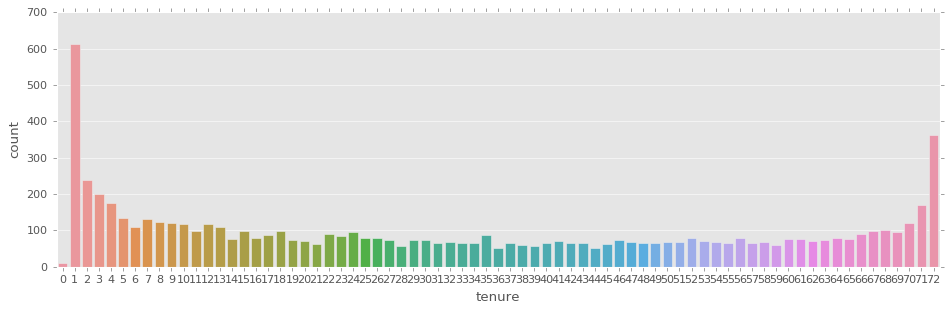

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(df['tenure'])
plt.tight_layout()

#PREPARAÇÃO DOS DADOS

##Balanceamento

Vou criar um novo dataset que contenha uma distibruição parecida entre os clientes que deram churn e os que não deram. Para isso, vou usar a função sample que escolhe aleatoriamente uma determinada quantidade de dados.

In [53]:
normal_sample = df[df['Churn'] == 'No'].sample(n=1869)

Concatenando os dados dos clientes que deram churn e os que não deram churn para atualizar o dataframe deixando ele balanceado



In [54]:
df = pd.concat([normal_sample, df[df['Churn'] == 'Yes']], axis=0)

Text(0.5, 1.0, 'Churn')

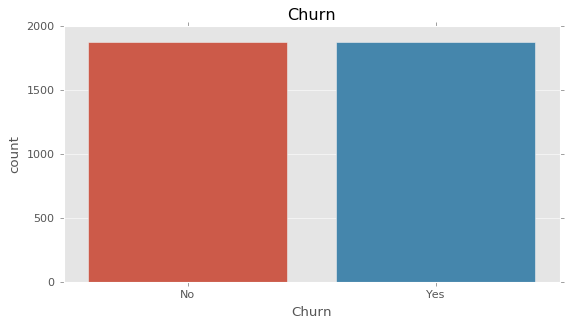

In [55]:
fig, ax = plt.subplots(figsize=(8,4))

num_bins = 40

sns.countplot('Churn', data=df, ax=ax)
ax.set_title('Churn')

##Alterando *dataset*

O ID do cliente será irrelevante para o processo de previsão de Churn, portanto irei excluir essa variável. 

A coluna de InternetService tem dados com nome 'No' e isso pode atrapalhar na hora de alterar os dados de 'No' e 'Yes' para 0 e 1. 
Por esse motivo, vamos tirar a coluna enquanto fazemos a alteração nos dados e concatenar posteriormente.

In [56]:
InternetService_df = df['InternetService']
df = df.drop('InternetService', axis=1)
df = df.replace({'No': 0, 'Yes': 1})
df = df.drop('customerID', axis=1)
df = pd.concat([df, InternetService_df], axis=1)

In [57]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
6458,Male,0,1,1,6,1,0,1,0,0,0,0,0,Month-to-month,1,Electronic check,49.15,295.65,0,DSL
4599,Female,0,1,1,52,1,0,0,0,1,0,0,0,One year,1,Bank transfer (automatic),50.95,2610.65,0,DSL
5222,Female,0,0,0,8,1,1,1,1,1,0,0,0,Month-to-month,1,Bank transfer (automatic),65.50,573.15,0,DSL


Como em MultipleLines é a respeito de clientes que tem mais de uma linha, pessoas que não têm nenhuma linha ficaram como 'No phone service'. Já que há uma coluna (PhoneService) que informa se o cliente tem ou não linha telefônica vou transformar 'No phone service' também em 0 para facilitar a análise dos dados. Durante a conversão posterior dos dados categóricos em dados numéricos algumas entradas estavam como 'No internet service' e na coluna do valor total algumas entradas estavam sem nenhum valor. Essas entradas foram substituídas por 0.

In [58]:
df = df.replace({'No phone service': 0})
df = df.replace({'No internet service': 0})
df = df.replace({' ': 0})

##*Dummy Values*

O principal objetivo das ​​*dummy values* é que elas são ferramentas que nos permitem representar variáveis ​​categóricas em técnicas estatísticas.
Quando uma variável categórica possui mais de duas categorias, ela pode ser representada por um conjunto de *dummy values*, com uma variável para cada categoria.



In [59]:
df = pd.get_dummies(df, columns=['gender', 'InternetService', 'Contract', 'PaymentMethod'])
df.head(3)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6458,0,1,1,6,1,0,1,0,0,0,0,0,1,49.15,295.65,0,0,1,1,0,0,1,0,0,0,0,1,0
4599,0,1,1,52,1,0,0,0,1,0,0,0,1,50.95,2610.65,0,1,0,1,0,0,0,1,0,1,0,0,0
5222,0,0,0,8,1,1,1,1,1,0,0,0,1,65.50,573.15,0,1,0,1,0,0,1,0,0,1,0,0,0


In [60]:
#Alterar a ordem dos dados
churn_df = df['Churn']
df = df.drop('Churn', axis=1)
df = pd.concat([df, churn_df], axis=1)

Agora que o *dataframe* já está "organizado" vamos verificar o formato dele, as primeiras entradas e também o tipo dos dados de cada coluna.

In [61]:
print(df.shape)
df.head(3)

(3738, 28)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
6458,0,1,1,6,1,0,1,0,0,0,0,0,1,49.15,295.65,0,1,1,0,0,1,0,0,0,0,1,0,0
4599,0,1,1,52,1,0,0,0,1,0,0,0,1,50.95,2610.65,1,0,1,0,0,0,1,0,1,0,0,0,0
5222,0,0,0,8,1,1,1,1,1,0,0,0,1,65.50,573.15,1,0,1,0,0,1,0,0,1,0,0,0,0


É importante alterar todos os dados para formato numérico pois a maioria dos algorítimos de Machine Learning esperam dados numéricos.

In [ ]:
df = df.apply(pd.to_numeric)

##StandardScaler

Antes de continuar com nossa análise, é importante não esquecer que nossos recursos de 'tenure', 'MonthlyCharges' e 'TotalCharges' não o foram "escalados". Muitos algoritmos de Machine Learning assumem que os dados estão padronizados na hora de gerar o modelo, ou seja, assumem que os dados estão todos na mesma escala…

In [ ]:
#Importar StandardScaler
from sklearn.preprocessing import StandardScaler


df_std = df.copy()
scaler = StandardScaler()
df_std['std_tenure'] = scaler.fit_transform(df_std['tenure'].values.reshape(-1, 1))
df_std['std_MonthlyCharges'] = scaler.fit_transform(df_std['MonthlyCharges'].values.reshape(-1, 1))
df_std['std_TotalCharges'] = scaler.fit_transform(df_std['TotalCharges'].values.reshape(-1, 1))

df_std.drop(['TotalCharges', 'std_MonthlyCharges', 'tenure'], axis=1, inplace=True)

#Visualizar novo dataset
df_std.head(3)

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,std_tenure,std_TotalCharges
3860,0,0,1,0,0,0,0,0,0,0,0,1,25.35,0,1,1,0,0,1,0,0,0,1,0,0,0,-0.353506,-0.664395
707,1,0,0,1,1,0,1,0,1,1,1,1,104.65,0,1,0,1,0,0,1,0,1,0,0,0,0,-0.019512,0.444801
4236,0,0,0,1,0,0,0,0,0,0,0,0,19.95,1,0,0,0,1,1,0,0,0,1,0,0,0,-1.104993,-0.917028


##Dividir entre conjuntos de Treino e Validação

Antes de proceder com a validação dos dados, devemos splitar os dados já existentes entre Treino e Validação. 

Para garantir que os conjuntos de Treino e Validação tenham a mesma quantidade de classes proporcionalmente, passamos stratify=True.

In [ ]:
#Importar train_test_split
from sklearn.model_selection import train_test_split

#Separar os dados entre feature matrix e target vector 
X = df_std.drop('Churn', axis=1)
y = df_std['Churn']
#Dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

## Instanciando modelos e realizando Cross Validation

Antes de mais nada, você precisa instanciar o objeto do classificador. 





In [ ]:
#Instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
svc = SVC()
lr = LogisticRegression(max_iter=3000)
xgb = XGBClassifier()

A validação cruzada é uma ferramenta muito útil para um cientista de dados para avaliar a eficácia do modelo, especialmente para lidar com overfitting e underfitting. Além disso, é útil determinar os hiperparâmetros do modelo, no sentido de que quais parâmetros resultarão no menor erro de teste.


**Os modelos escolhidos para comparar na Cross Validation foram:**

- **Random Forest:** É um método de conjunto (baseado na abordagem dividir e conquistar) de árvores de decisão geradas em um conjunto de dados dividido aleatoriamente. Essa coleção de classificadores de árvore de decisão também é conhecida como floresta. As árvores de decisão individuais são geradas usando um indicador de seleção de atributo, como ganho de informação, razão de ganho e índice de Gini para cada atributo. Cada árvore depende de uma amostra aleatória independente. Em um problema de classificação, cada árvore vota e a classe mais popular é escolhida como o resultado final.

In [ ]:
#Cross Validation Random Forest
cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy').mean()

0.7506304016268428

- **Decision Tree:** Uma árvore de decisão é um fluxograma semelhante a uma estrutura de árvore, em que cada nó interno denota um teste em um atributo, cada ramificação representa um resultado do teste e cada nó folha (nó terminal) contém um rótulo de classe.

In [ ]:
#Cross Validation Decision Tree
cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy').mean()

0.6618022369089984

- **Support Vector Machine:** O objetivo do algoritmo da máquina de vetores de suporte é encontrar um hiperplano em um espaço N-dimensional (N - o número de recursos) que classifica distintamente os pontos de dados.

In [ ]:
#Cross Validation Support Vector 
cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy').mean()

0.7031723436705644

- **Logistic Regression:** A regressão logística é um processo de modelagem da probabilidade de um resultado discreto dada uma variável de entrada. Os modelos de regressão logística mais comuns são um resultado binário; algo que pode assumir dois valores, como verdadeiro / falso, sim / não e assim por diante.

In [ ]:
#Cross Validation Logistic Regression 
cross_val_score(lr, X_train, y_train, cv=10, scoring='accuracy').mean()

0.7656215048296898




- **XGboost:** O XGBoost é um algoritmo de aprendizado de máquina, baseado em árvore de decisão e que utiliza uma estrutura de Gradient boosting. A implementação do algoritmo foi projetada para eficiência de tempo de computação e recursos de memória.


In [ ]:
#Cross Validation X boost 
print(cross_val_score(xgb, X_train, y_train, cv=10, scoring='accuracy').mean())

0.7659875444839858


Como podemos ver Logistic Regression teve o melhor resultado de acurácia na Cross Validation e por isso seguiremos com esse modelo.
Em seguida, você pode aplicar o modelo treinado no teste e verificar qual o desempenho dele nestes dados ‘novos’ (não foram usados na construção do modelo):

In [ ]:
#Fit do modelo (treinar)
lr.fit(X_train, y_train)

#Fazer previsões em cima de novos dados
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)

Veja que salvamos a predição no objeto y_pred. Isto porque queremos compará-lo com y_test. Em outras palavras, queremos saber qual a diferença entre o que o modelo previu e o que realmente ocorreu.

##Avaliação do desempenho do modelo

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho. Neste tipo de problema, originalmente desbalanceado, a acurácia não é uma métrica adequada. Observe a matriz de confusão para ver a taxa de acertos para casos que deram churn, ou pela coluna recall do Relatório de Classificação.

In [ ]:
# imprimir relatório de classificação
print(classification_report(y_test, y_pred))

print('acurácia: ', accuracy_score(y_test, y_pred))
print('AUC: ', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       468
           1       0.75      0.78      0.76       467

    accuracy                           0.76       935
   macro avg       0.76      0.76      0.76       935
weighted avg       0.76      0.76      0.76       935

acurácia:  0.760427807486631
AUC:  0.7604458353923023


Por fim, vamos plotar a matriz de confusão para ter, pictorialmente, uma visão do desempenho por classes.



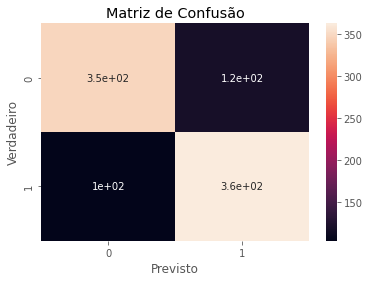

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax=ax)

ax.set_title("Matriz de Confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")

plt.show()

##Conclusão

O *Churn* é um problema complexo que requer uma quantidade substancial de planejamento antes de usar algoritmos de machine learning. No entanto, é também uma aplicação de data science importante para sinalizar à empresa como anda o crescimento ou a redução da sua base de clientes, além de permitir que a empresa tenha o mínimo de previsibilidade.

A partir desse projeto foi possível verificar a importância da utilização de métodos como *Cross Validation* para escolha do algoritmo com melhor fit para a previsão dos dados.